## <u>ASSIGNMENT 07: COMP7116001 - COMPUTER VISION 2022</u>

<table>
    <tr>
        <th style="text-align:left;">Group</th>
        <td style="text-align:left;" colspan="5">6</td>
    </tr>
    <tr>
        <th style="text-align:left;">1st Member Name</th>
        <td style="text-align:left;">Cindy Amanda Onggirawan</td>
        <th style="text-align:left;">2nd Member Name</th>
        <td style="text-align:left;">Jocelyn Michelle Kho</td>
        <th style="text-align:left;">Lecturer</th>
        <td style="text-align:left;">Dr. Ir. Diaz D. Santika, M.Sc.</td>
    </tr>
    <tr>
        <th style="text-align:left;">NIM</th>
        <td style="text-align:left;">2440055351</td>
        <th style="text-align:left;">NIM</th>
        <td style="text-align:left;">2440039796</td>
        <th style="text-align:left;">Lecturer Code</th>
        <td style="text-align:left;">D1159</td>
    </tr>
    <tr>
        <th style="text-align:left;">Class</th>
        <td style="text-align:left;" colspan="5">LA01</td>
    </tr>
</table>

### Image classification using Bag of Visual Words (BOVW)

Pertama-tama, kita mengimpor semua library yang dibutuhkan.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.cluster.vq import kmeans, vq
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

### 1. Selecting representative images from an image dataset.

Kita melihat nama kelas dalam training dataset dan simpan dalam sebuah list. Disini, kita menggunakan nama folder sebagai nama kelas.

In [2]:
train_path = './Dataset/Train'
training_names = os.listdir(train_path)

In [3]:
training_names

['Hotdog', 'Hamburger']

Kita perlu mendapatkan path ke semua gambar dan menyimpannya dalam list image_paths. Kita juga memperlukan label yang sesuai dengan masing-masing image_paths. Fungsi makeImagePathList akan mengembalikan gabungan dari path folder dengan filename yang ada.

In [4]:
def makeImagePathList(path):
    return [os.path.join(path, filename) for filename in os.listdir(path)]

Fungsi makeClassList akan mengembalikan 20 path gambar yang telah kita dapatkan menggunakan fungsi makeImagePathList, disertai dengan masing-masing label kelasnya.

In [5]:
def makeClassList(type_path, type_names, image_paths, image_classes):
    class_id = 0
    
    for type_name in type_names:
        dir = os.path.join(type_path, type_name)
        class_path = makeImagePathList(dir)
        image_paths += class_path
        image_classes += [class_id] * len(class_path)
        class_id += 1
    
    return image_paths, image_classes

In [6]:
train_image_paths = []
train_image_classes = []
train_image_paths, train_image_classes = makeClassList(train_path, training_names,
                                                       train_image_paths, train_image_classes)

In [7]:
train_image_paths

['./Dataset/Train/Hotdog/8.jpg',
 './Dataset/Train/Hotdog/9.jpg',
 './Dataset/Train/Hotdog/10.jpg',
 './Dataset/Train/Hotdog/4.jpg',
 './Dataset/Train/Hotdog/5.jpg',
 './Dataset/Train/Hotdog/7.jpg',
 './Dataset/Train/Hotdog/6.jpg',
 './Dataset/Train/Hotdog/2.jpg',
 './Dataset/Train/Hotdog/3.jpg',
 './Dataset/Train/Hotdog/1.jpg',
 './Dataset/Train/Hamburger/8.jpg',
 './Dataset/Train/Hamburger/9.jpg',
 './Dataset/Train/Hamburger/10.jpg',
 './Dataset/Train/Hamburger/4.jpg',
 './Dataset/Train/Hamburger/5.jpg',
 './Dataset/Train/Hamburger/7.jpg',
 './Dataset/Train/Hamburger/6.jpg',
 './Dataset/Train/Hamburger/2.jpg',
 './Dataset/Train/Hamburger/3.jpg',
 './Dataset/Train/Hamburger/1.jpg']

In [8]:
train_image_classes

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

### 2. Collect all the SURF descriptors from the images in 1. Actually, SURF is a <u>patented algorithm</u>, hence not available in each openCV version, so we use the alternative, which is SIFT.

Kita membuat object SIFT untuk mengekstrak keypoints dan descriptors gambar.

In [9]:
sift = cv2.SIFT_create()

Fungsi makeDesList akan mengembalikan list dari gambar BGR dan descriptors yang telah diperoleh dengan algoritma SIFT.

In [10]:
def makeDesList(image_list, des_list, image_paths):
    for image_path in image_paths:
        image = cv2.imread(image_path)
        image_list.append(image)
        kp, des = sift.detectAndCompute(image, None)
        des_list.append((image_path, des))
    
    return image_list, des_list

In [11]:
train_image_list = []
train_des_list = []
train_image_list, train_des_list = makeDesList(train_image_list, train_des_list, 
                                               train_image_paths)

Jadi, di dalam train_des_list, akan ada string path dan array descriptors.

In [12]:
train_des_list

[('./Dataset/Train/Hotdog/8.jpg',
  array([[ 66.,   6.,   0., ...,   0.,   0.,   7.],
         [126., 110.,   0., ...,   0.,   0.,   7.],
         [  4.,   3.,   0., ...,   0.,   0.,   4.],
         ...,
         [  0.,   0.,   0., ...,   4.,   1.,   7.],
         [ 52., 105.,   5., ...,   0.,   0.,   3.],
         [  0.,   0.,   1., ...,   0.,   0.,   0.]], dtype=float32)),
 ('./Dataset/Train/Hotdog/9.jpg',
  array([[ 0.,  1.,  8., ...,  0.,  0.,  1.],
         [32.,  7.,  7., ...,  0.,  3.,  6.],
         [ 0.,  0.,  0., ..., 39., 11.,  1.],
         ...,
         [ 4.,  0.,  1., ...,  7.,  0.,  0.],
         [ 1., 10., 27., ...,  7.,  2.,  0.],
         [ 0.,  0.,  3., ...,  0.,  0.,  0.]], dtype=float32)),
 ('./Dataset/Train/Hotdog/10.jpg',
  array([[15., 10.,  7., ...,  8.,  7.,  1.],
         [12., 40., 19., ..., 14., 11., 12.],
         [ 4., 48., 43., ..., 22.,  5.,  1.],
         ...,
         [18., 37., 20., ..., 39., 10.,  7.],
         [ 2., 12., 22., ...,  0.,  0.,  1.],
 

Fungsi showImages akan memperlihatkan semua gambar training dan testing, disertai dengan kelas actual dan predictednya.

In [13]:
def showImages(dir_type):
    if dir_type == 'train':
        fig, ax = plt.subplots(4, 5)
        fig.set_size_inches(16, 8)
        y = 0
        for i in range(4):
            for j in range(5):
                rgb_image = cv2.cvtColor(train_image_list[y], cv2.COLOR_BGR2RGB)
                ax[i,j].imshow(rgb_image)
                ax[i,j].set_title("{}".format(training_names[train_image_classes[y]]))
                ax[i,j].set_xticks([])
                ax[i,j].set_yticks([])
                ax[i,j].grid(False)
                y += 1
        plt.tight_layout()
    elif dir_type == 'test':
        fig, ax = plt.subplots(2, 2)
        fig.set_size_inches(12, 6)
        y = 0
        for i in range(2):
            for j in range(2):
                rgb_image = cv2.cvtColor(test_image_list[y], cv2.COLOR_BGR2RGB)
                ax[i,j].imshow(rgb_image)
                ax[i,j].set_title("{}".format(testing_names[test_image_classes[y]]))
                ax[i,j].set_xticks([])
                ax[i,j].set_yticks([])
                ax[i,j].grid(False)
                y += 1
        plt.tight_layout()
    else:
        fig, ax = plt.subplots(2, 2)
        fig.set_size_inches(12, 6)
        y = 0
        for i in range(2):
            for j in range(2):
                rgb_image = cv2.cvtColor(test_image_list[y], cv2.COLOR_BGR2RGB)
                ax[i,j].imshow(rgb_image)
                ax[i,j].set_title("Act: {} | Pred: {}".format(testing_names[test_image_classes[y]],
                                                              testing_names[pred_image_classes[y]]))
                ax[i,j].set_xticks([])
                ax[i,j].set_yticks([])
                ax[i,j].grid(False)
                y += 1
        plt.tight_layout()

Kita lihat dulu semua gambar training beserta kelas actualnya.

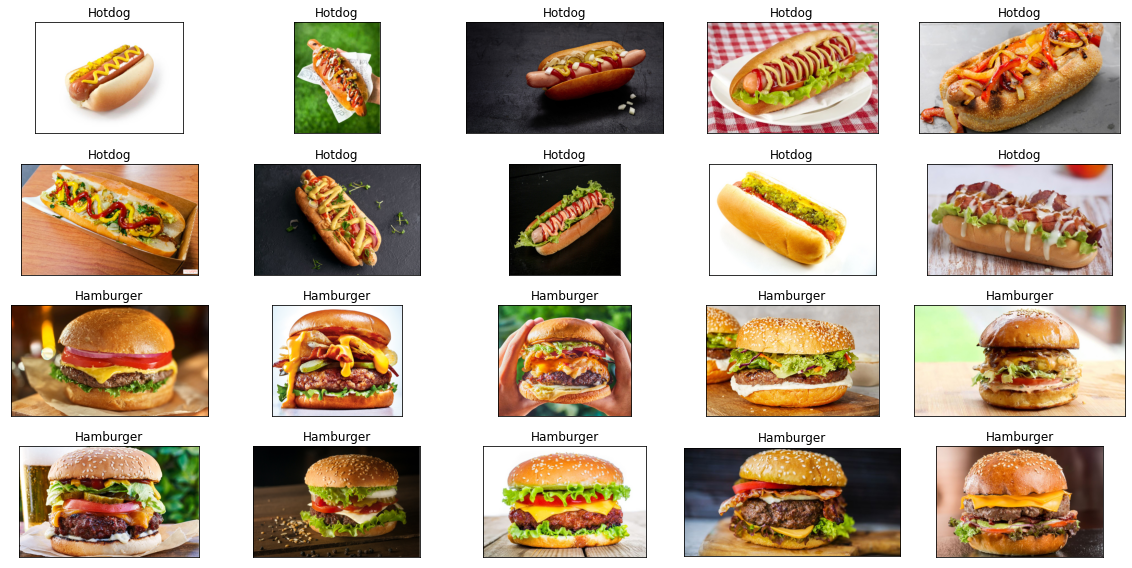

In [14]:
showImages('train')

Fungsi makeVstack akan menumpuk semua descriptors secara vertikal. Array ini yang nantinya akan digunakan sebagai parameter kmeans.

In [15]:
def makeVstack(des_list, descriptors):
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    
    return descriptors

In [16]:
train_descriptors = train_des_list[0][1]
train_descriptors = makeVstack(train_des_list, train_descriptors)

In [17]:
train_descriptors

array([[ 66.,   6.,   0., ...,   0.,   0.,   7.],
       [126., 110.,   0., ...,   0.,   0.,   7.],
       [  4.,   3.,   0., ...,   0.,   0.,   4.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  2.,  15.,   7., ...,  13.,  12.,  10.],
       [ 56.,   4.,   2., ...,   0.,   0.,   0.]], dtype=float32)

Kita mengubah integers menjadi float karena kmeans hanya bisa diterapkan pada float.

In [18]:
train_descriptors_float = train_descriptors.astype(float)

In [19]:
train_descriptors_float

array([[ 66.,   6.,   0., ...,   0.,   0.,   7.],
       [126., 110.,   0., ...,   0.,   0.,   7.],
       [  4.,   3.,   0., ...,   0.,   0.,   4.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  2.,  15.,   7., ...,  13.,  12.,  10.],
       [ 56.,   4.,   2., ...,   0.,   0.,   0.]])

### 3. Cluster these descriptors using K Means into k number of clusters where k is a number you set. The center of these clusters are the "visual words" i.e. representative features in your database of images.

Kita akan melakukan k-means clustering and vector quantization. Nilai k = 2 karena hanya ada 2 cluster, yaitu Hotdog dan Hamburger.

In [20]:
k = 2
centroids, variance = kmeans(train_descriptors_float, k, 1)

In [21]:
centroids

array([[ 22.86090301,  18.59569474,  16.92058735,  19.3073619 ,
         22.57761462,  17.57501748,  15.48466687,  18.35710718,
         46.20402557,  28.57771451,  20.42822895,  21.03486165,
         24.89606433,  18.80486465,  17.13659974,  25.6991809 ,
         76.01693138,  30.40979922,  13.93452203,  11.86619718,
         13.8316352 ,  15.02931775,  21.72864849,  48.07601638,
         33.4990011 ,  14.54634902,   9.24223354,  11.10673259,
         21.12676056,  22.92383378,  25.49990011,  31.89032065,
         27.93941664,  22.6940865 ,  19.39017081,  21.90080911,
         26.71865947,  22.50074918,  19.7320947 ,  22.57262012,
         58.52622116,  34.16287084,  31.26056338,  38.27544701,
         41.78443712,  26.21955849,  15.0641794 ,  18.58530616,
        127.62586155,  51.67920288,  16.35241235,  10.70237738,
         10.47098192,  10.00394566,  14.15408051,  48.39276796,
         45.73549096,  15.19488563,   9.81285586,  18.90560384,
         34.85211268,  31.20877035,  24.

### 4. For every image in the database, you are going to create a vector V that counts how frequently the different features in the dictionary occurs so each image would be represented by a vector. You obtain this vector for an image by extracting SIFT descriptors in the image. For each SIFT descriptor in the image, find the closest cluster center (using Euclidean distance) in the codebook/dictionary and increment its corresponding count in the vector V by 1.

Kita akan menghitung histogram dari fitur yang ada dan menyatakannya sebagai vektor.

In [22]:
def makeFeatureList(image_paths, des_list):
    image_features = np.zeros((len(image_paths), k), 'float32')

    for i in range(len(image_paths)):
        words, distance = vq(des_list[i][1], centroids)
        for w in words:
            image_features[i][w] += 1
    
    return image_features

In [23]:
train_image_features = makeFeatureList(train_image_paths, train_des_list)

In [24]:
train_image_features

array([[ 230.,  153.],
       [ 527.,  457.],
       [ 413.,  311.],
       [1615., 1380.],
       [1742., 2280.],
       [1006.,  790.],
       [ 740.,  702.],
       [ 477.,  508.],
       [ 448.,  369.],
       [ 994.,  902.],
       [ 847.,  856.],
       [ 920.,  749.],
       [1176., 1059.],
       [1996., 1970.],
       [ 754.,  760.],
       [1242., 1060.],
       [ 894.,  899.],
       [1380., 1082.],
       [1258., 1202.],
       [1342., 1444.]], dtype=float32)

### 5. At this stage, you might want to normalize the histogram by dividing each entry by the sum of all the entries so that images with very different number of SIFT key-points found can be made comparable.

Kita melakukan standarisasi fitur dengan menghilangkan rata-rata dan penskalaan ke varian unit dengan cara normalisasi.

In [25]:
stdSlr = StandardScaler().fit(train_image_features)
train_image_features = stdSlr.transform(train_image_features)

Kita melatih model dengan linear SVM untuk membedakan vektor yang sesuai dengan gambar training.

In [26]:
clf = LinearSVC(max_iter=10000)
clf.fit(train_image_features, np.array(train_image_classes))

LinearSVC(max_iter=10000)

### 6. Now, to compare 2 images, you compare this new vector V instead of the SIFT descriptors themselves. It is recommended to use cosine similarity to evaluate how close your query image with images in the database.

Kita melihat nama kelas dalam testing dataset dan simpan dalam sebuah list. Disini, kita menggunakan nama folder sebagai nama kelas.

In [27]:
test_path = './Dataset/Test'
testing_names = os.listdir(test_path)

In [28]:
testing_names

['Hotdog', 'Hamburger']

Kita perlu mendapatkan path ke semua gambar dan menyimpannya dalam list image_paths. Kita juga memperlukan label yang sesuai dengan masing-masing image_paths. Sehingga, kita memanggil fungsi makeClassList yang akan mengembalikan 20 path gambar dengan masing-masing label kelasnya.

In [29]:
test_image_paths = []
test_image_classes = []
test_image_paths, test_image_classes = makeClassList(test_path, testing_names,
                                                     test_image_paths, test_image_classes)

In [30]:
test_image_paths

['./Dataset/Test/Hotdog/2.jpg',
 './Dataset/Test/Hotdog/1.jpg',
 './Dataset/Test/Hamburger/2.jpg',
 './Dataset/Test/Hamburger/1.jpg']

In [31]:
test_image_classes

[0, 0, 1, 1]

Kita memanggil fungsi makeDesList untuk membuat list gambar BGR dan descriptors yang telah diperoleh dengan algoritma SIFT.

In [32]:
test_image_list = []
test_des_list = []
test_image_list, test_des_list = makeDesList(test_image_list, test_des_list, 
                                             test_image_paths)

Jadi, di dalam test_des_list, akan ada string path dan array descriptors.

In [33]:
test_des_list

[('./Dataset/Test/Hotdog/2.jpg',
  array([[ 1.,  2.,  6., ...,  0.,  0., 15.],
         [31., 86., 32., ...,  5.,  4.,  3.],
         [41., 35.,  7., ...,  1.,  4.,  7.],
         ...,
         [ 2.,  8., 10., ..., 11.,  0.,  1.],
         [ 0.,  1., 10., ..., 17.,  0.,  0.],
         [ 0.,  1., 10., ...,  1.,  1., 44.]], dtype=float32)),
 ('./Dataset/Test/Hotdog/1.jpg',
  array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
         [41.,  1.,  0., ...,  0.,  0.,  0.],
         [15.,  2.,  1., ...,  1.,  1.,  0.],
         ...,
         [21., 10.,  1., ..., 33.,  5., 13.],
         [24.,  9.,  1., ...,  7.,  1.,  1.],
         [25.,  8.,  0., ...,  0.,  0.,  0.]], dtype=float32)),
 ('./Dataset/Test/Hamburger/2.jpg',
  array([[ 0.,  8., 12., ...,  0.,  0.,  0.],
         [ 6., 32., 52., ...,  0.,  0.,  2.],
         [ 1.,  0.,  0., ...,  0.,  0., 16.],
         ...,
         [63., 22.,  4., ...,  0.,  0.,  1.],
         [12., 17., 72., ...,  0.,  0.,  0.],
         [ 1.,  0.,  0., ...,  0.,  0.

Kita lihat dulu semua gambar testing beserta kelas actualnya.

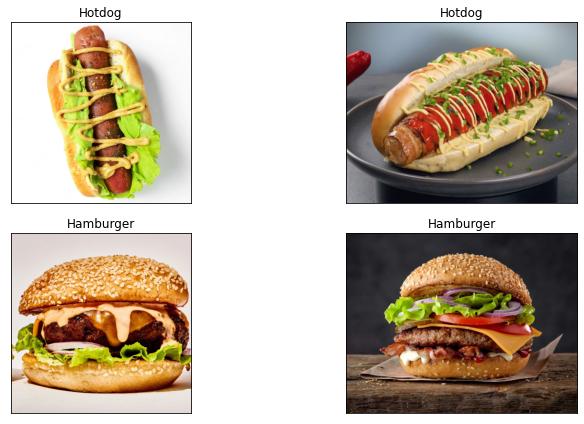

In [34]:
showImages('test')

Fungsi makeVstack akan menumpuk semua descriptors secara vertikal.

In [35]:
test_descriptors = test_des_list[0][1]
test_descriptors = makeVstack(test_des_list, test_descriptors)

In [36]:
test_descriptors

array([[  1.,   2.,   6., ...,   0.,   0.,  15.],
       [ 31.,  86.,  32., ...,   5.,   4.,   3.],
       [ 41.,  35.,   7., ...,   1.,   4.,   7.],
       ...,
       [ 82.,  55.,   2., ...,  88.,  76.,  10.],
       [  2.,   1.,   3., ...,   0.,   0., 132.],
       [  1.,  21., 125., ...,  45.,  69.,  50.]], dtype=float32)

Kita akan menghitung histogram dari fitur yang ada dan menyatakannya sebagai vektor.

In [37]:
test_image_features = makeFeatureList(test_image_paths, test_des_list)

In [38]:
test_image_features

array([[ 448.,  403.],
       [ 786.,  622.],
       [1160., 1065.],
       [1240., 1135.]], dtype=float32)

Kita melakukan standarisasi fitur dengan menghilangkan rata-rata dan penskalaan ke varian unit dengan cara normalisasi.

In [39]:
test_image_features = stdSlr.transform(test_image_features)

Kita akan menggunakan model clf yang telah kita fit sebelumnya dengan train_image_features untuk memprediksi kelas berdasarkan test_image_features.

In [40]:
pred_image_classes = clf.predict(test_image_features)

In [41]:
print("actual_class    = "  + str(np.array(test_image_classes)))
print("predicted_class = "  + str(pred_image_classes))

actual_class    = [0 0 1 1]
predicted_class = [0 0 1 1]


Kita menghitung akurasi untuk membandingkan kecocokan antara kelas actual dan predictednya.

In [42]:
accuracy = accuracy_score(test_image_classes, pred_image_classes) * 100

In [43]:
print("accuracy = " + str(int(accuracy)) + "%")

accuracy = 100%


Akhirnya, kita lihat semua gambar testing beserta kelas actual dan predictednya.

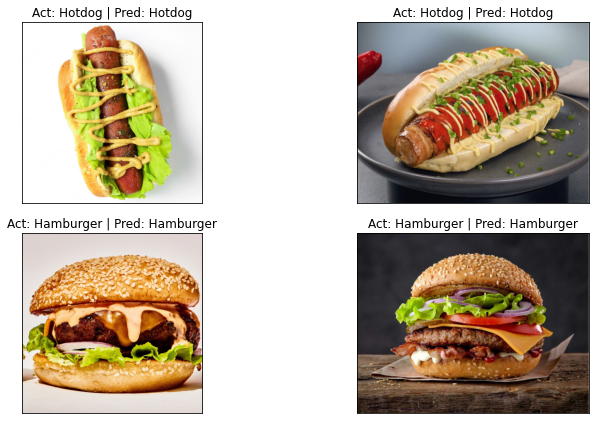

In [44]:
showImages('pred')

## THANK YOU